In [119]:
# Install the necessary packages
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [120]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [121]:
# Constant variables
start_date = '2024-01-01'
end_date = '2024-03-01'
tickers = ['DOTUSDT', 'LINKUSDT']
significance_level = 0.05

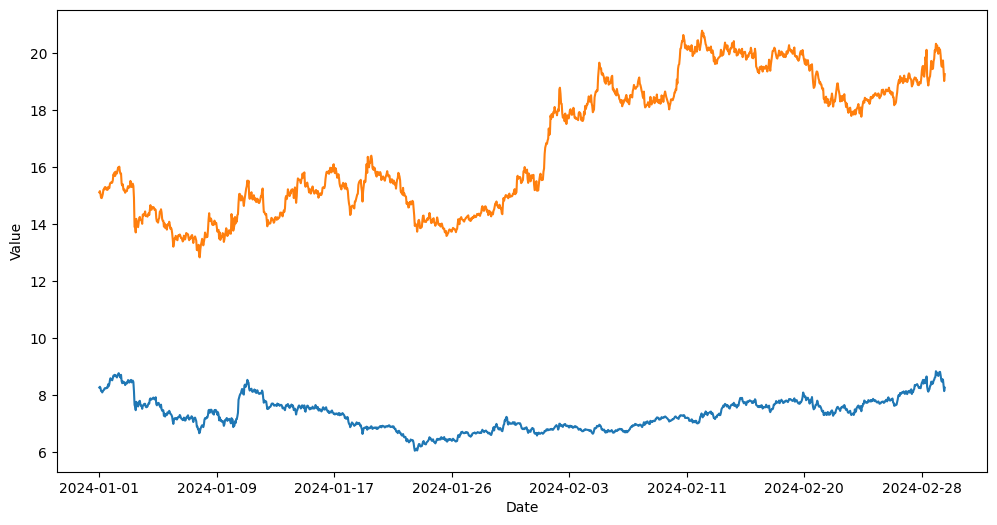

In [122]:
# Load stock data
from src.backtest.data_loader import DataLoader

loader = DataLoader(interval="1h")
data = loader.load(tickers, start=start_date, end=end_date, data_dir='../data')

fig = plt.subplots(figsize=(12, 6))
plt.plot(data.index, data[tickers[0]], data[tickers[1]])
plt.xlabel('Date')
plt.xticks(data.index[::200])
plt.ylabel('Value')
plt.show()

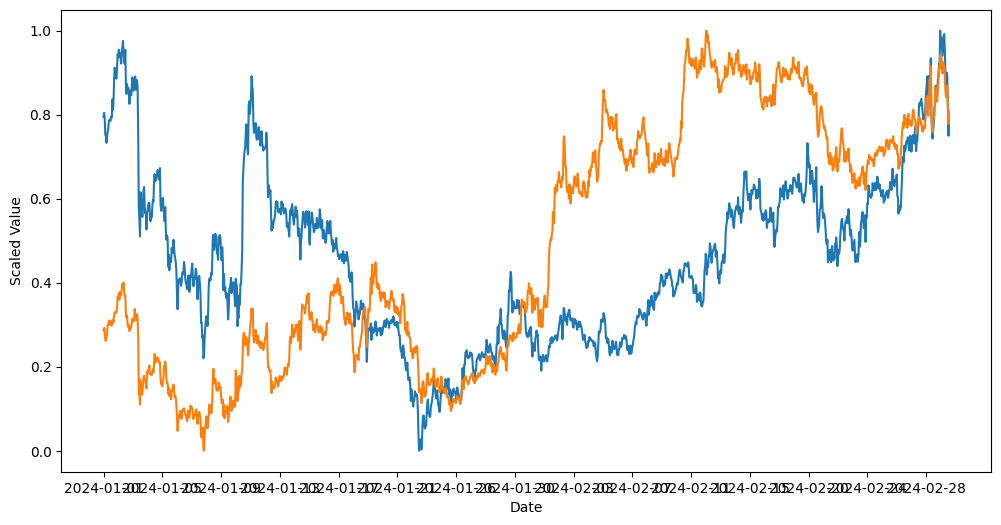

In [123]:
from loaders.data_processing import minmax_scale

# Min-max normalization of prices
data_scaled = pd.DataFrame()
data_scaled[tickers[0]] = minmax_scale(data[tickers[0]])
data_scaled[tickers[1]] = minmax_scale(data[tickers[1]])

fig = plt.subplots(figsize=(12, 6))
plt.plot(data.index, data_scaled[tickers[0]], data_scaled[tickers[1]])
plt.xlabel('Date')
plt.xticks(data.index[::100])
plt.ylabel('Scaled Value')
plt.show()

In [124]:
# Pearson's correlation
prices_correlation = data[tickers[0]].corr(data[tickers[1]])
print("Correlation of prices:", prices_correlation)

Correlation of prices: 0.30445924452289846


In [125]:
# Log-returns
price_cols = ['DOTUSDT', 'LINKUSDT']
returns = np.log(data[price_cols] / data[price_cols].shift(1))
returns = returns.dropna()

# Pearson's correlation of log-returns
correlation = returns['DOTUSDT'].corr(returns['LINKUSDT'])
print("Correlation of log-returns:", correlation)

Correlation of log-returns: 0.7119603679120217


In [126]:
# Perform cointegration test
score, p_value, _ = coint(data[tickers[0]], data[tickers[1]])
print(f'Cointegration test p-value: {p_value}\nSignificance level: {significance_level}')

if p_value < significance_level:
    print("The pairs are cointegrated.")
else:
    print("The pairs are not cointegrated.")

Cointegration test p-value: 0.435937962619695
Significance level: 0.05
The pairs are not cointegrated.


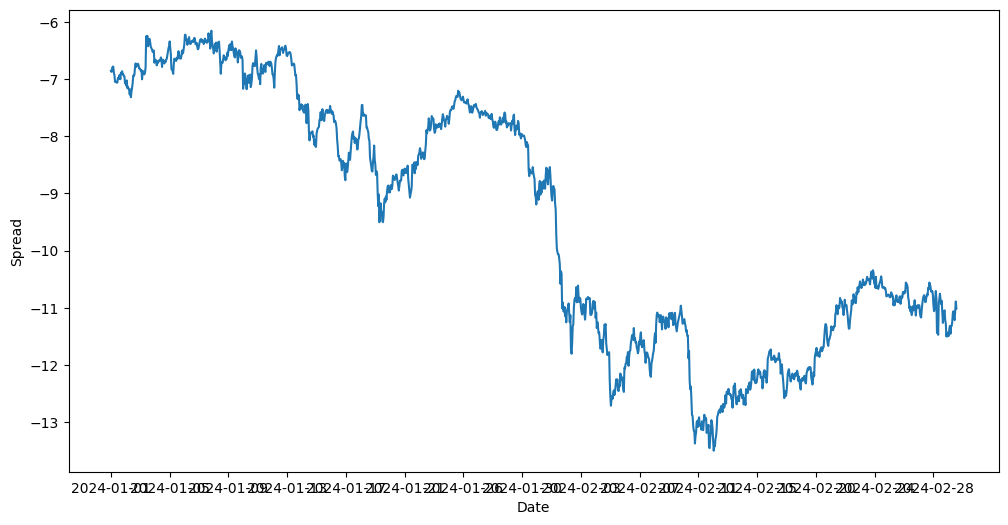

In [127]:
# Calculate spread
data['Spread'] = data[tickers[0]] - data[tickers[1]]

fig = plt.subplots(figsize=(12, 6))
plt.plot(data.index, data['Spread'])
plt.xlabel('Date')
plt.xticks(data.index[::100])
plt.ylabel('Spread')
plt.show()

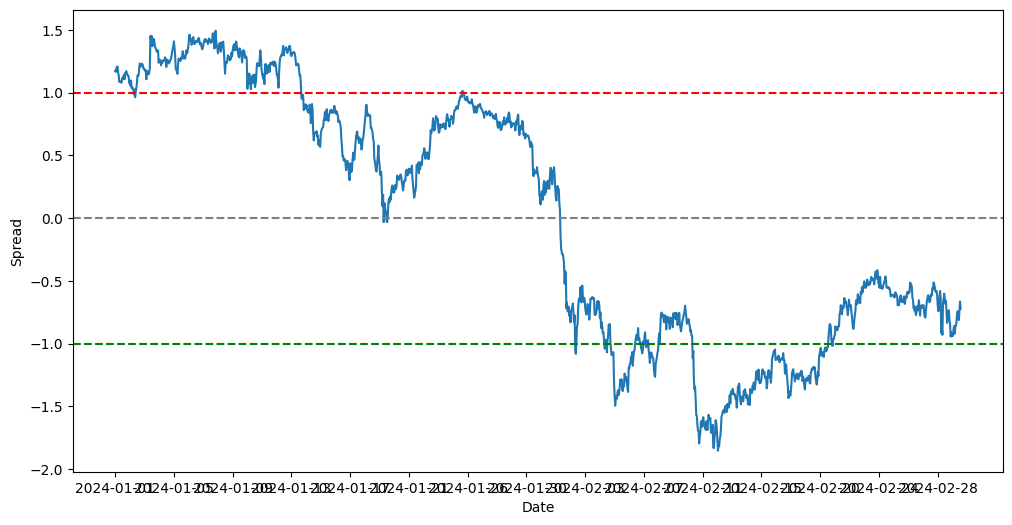

In [128]:
# Calculate z-score
data['Z-Score'] = (data['Spread'] - data['Spread'].mean()) / data['Spread'].std()

# Set thresholds for entering and exiting trades
entry_threshold=1.0
exit_threshold=0.0

fig = plt.subplots(figsize=(12, 6))
plt.plot(data.index, data['Z-Score'])
plt.xlabel('Date')
plt.xticks(data.index[::100])
plt.ylabel('Spread')
plt.axhline(entry_threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-entry_threshold, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(exit_threshold, color='grey', linestyle='--', label='Exit Threshold')
plt.show()

In [129]:
from src.strategy import PairsTradingStrategy

# Initialize strategy
strategy = PairsTradingStrategy(tickers=tickers, entry_threshold=1.0, exit_threshold=0.0, size=1.0)

In [130]:
from src.strategy import BacktestEngine

# Initialize and run backtest engine
engine = BacktestEngine(data=data, strategy=strategy)
results, stats = engine.run()
print(f"Backtest statistics: {stats}")

Backtest statistics: {'Total Return %': np.float64(67.3), 'Trades': 3, 'Mean Trade Return %': np.float64(0.0424), 'Sharpe Approx': np.float64(0.97)}


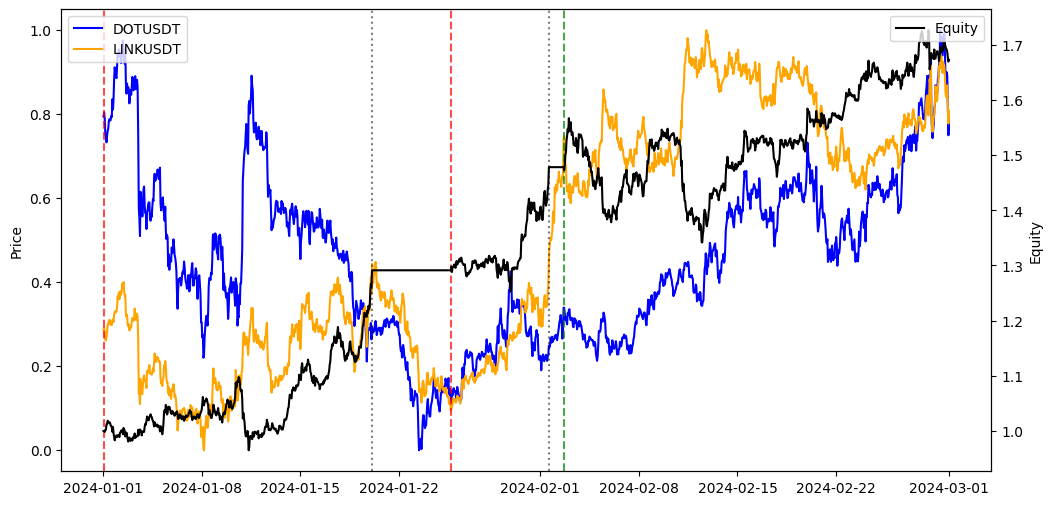

In [131]:
# Plot results
engine.plot_results(data_scaled)